In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import xarray as xr
import h5py
from tqdm import tqdm
import time

from RPLB_acc_NoSTC_2D import RPLB_acc_NoSTC_2D
from RPLB_acc_NoSTCApril import RPLB_acc_NoSTCApril
from RPLB_acc_NoSTCApril_2D import RPLB_acc_NoSTCApril_2D

In [9]:
c = 2.9979e8
lambda_0 = 1800e-9  # central wavelength
omega_0 = 2*np.pi*c/lambda_0

s = 57.5
tau_FWHM = np.sqrt(2)*s*np.sqrt(2**(2/(s+1))-1)/omega_0
tau_0 = s*np.sqrt(np.exp(2/(s+1))-1)/omega_0
# print(tau_0)

NA = 0.075
half_angle = np.arcsin(NA)
a = 2/(np.sin(half_angle)*np.tan(half_angle)*2*np.pi/lambda_0)  # set confocal parameter
w_0 = 2/(np.tan(half_angle)*2*np.pi/lambda_0)  # set beam waist
# print('{0:.3g}'.format(1e6*w_0))

P = 100e12  # FL power
t_0 = -10*tau_0

44206690.2063064
40161671.244529195
41112223.938167


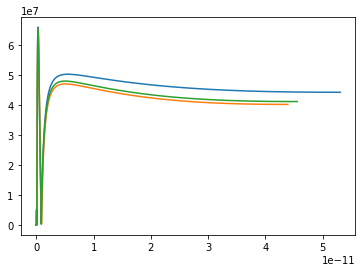

In [10]:
# testing on-axis only, comparing April model to standard model

r_0 = 0.0*w_0

t, z, r, v_z, v_r, KE = RPLB_acc_NoSTC_2D(lambda_0, tau_0, w_0, P, 0.0, 0.0, t_0, 0.0, r_0, 0.0)
t_April, z, beta, KE_April = RPLB_acc_NoSTCApril(lambda_0, s, a, P, 0.0, t_0, 0.0, 0.0)
t_April2D, z, r, v_z, v_r, KE_April2D = RPLB_acc_NoSTCApril_2D(lambda_0, s, a, P, 0.0, t_0, 0.0, r_0, 0.0)

print(KE[-1])
print(KE_April[-1])
print(KE_April2D[-1])

plt.plot(t, KE)
plt.plot(t_April, KE_April)
plt.plot(t_April2D, KE_April2D)

51971129.65499767
8351867.618547705


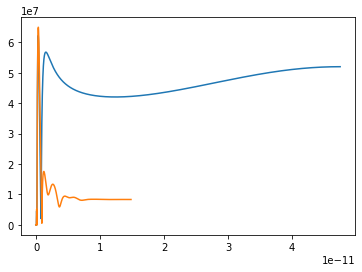

In [11]:
# testing one off-axis position, comparing April model to standard model

r_0 = 0.05*w_0

t, z, r, v_z, v_r, KE = RPLB_acc_NoSTC_2D(lambda_0, tau_0, w_0, P, 0.0, 0.0, t_0, 0.0, r_0, 0.0)
t_April2D, z, r, v_z, v_r, KE_April2D = RPLB_acc_NoSTCApril_2D(lambda_0, s, a, P, 0.0, t_0, 0.0, r_0, 0.0)

print(KE[-1])
print(KE_April2D[-1])

plt.plot(t, KE)
plt.plot(t_April2D, KE_April2D)

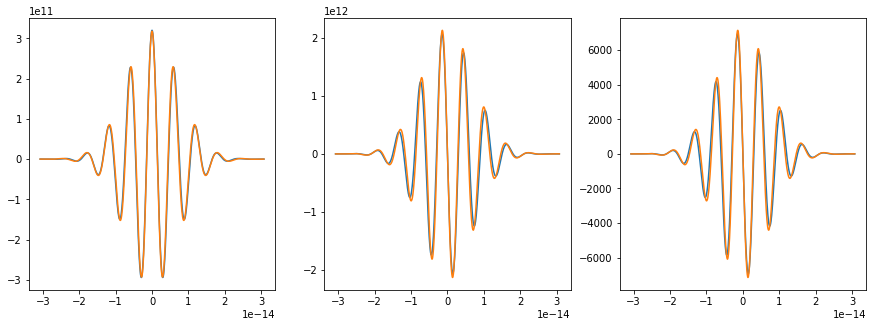

In [19]:
## comparing field equations in time at a chosen r and z
e_0 = 8.85418782e-12

NA = 0.1
half_angle = np.arcsin(NA)
a = 2/(np.sin(half_angle)*np.tan(half_angle)*2*np.pi/lambda_0)  # set confocal parameter
w_0 = 2/(np.tan(half_angle)*2*np.pi/lambda_0)  # set beam waist

P = 1e12  # FL power
Psi_0 = 0.0*np.pi
# Group Delay Dispersion s^2
phi_2 = 0*(1e-15)**2
# stretched pulse duration
tau = np.sqrt(tau_0**2 + (2*phi_2/tau_0)**2)

time = np.linspace(-3*tau_0, 3*tau_0, 1000)

# original (Salamin) field model
# calculate Rayleigh range
z_R = (omega_0*w_0**2)/(2*c)
# perturbation parameter
eps = w_0/z_R
# amplitude factor
# amplitude factor
P_corr = 1 + 3*(eps/2)**2 + 9*(eps/2)**4
Amp = np.sqrt(8*P/(P_corr*np.pi*e_0*c)) * (omega_0/(2*c))

r = 0.5*w_0
z = 0.0*z_R

rho = r/w_0

phi_G = np.arctan(z/z_R)
w = w_0*np.sqrt(1+(z/z_R)**2)
R_inv = z/(z**2 + z_R**2)
phi_norm = Psi_0-(omega_0/c)*(0.0*z+(R_inv*(rho*w_0)**2)/2)+omega_0*time
trans = np.exp(-(rho*w_0/w)**2)

c_2 = (w_0/w)**2 * np.exp(1j*(phi_norm + 2*phi_G))
c_3 = (w_0/w)**3 * np.exp(1j*(phi_norm + 3*phi_G))
c_4 = (w_0/w)**4 * np.exp(1j*(phi_norm + 4*phi_G))
c_5 = (w_0/w)**5 * np.exp(1j*(phi_norm + 5*phi_G))
c_6 = (w_0/w)**6 * np.exp(1j*(phi_norm + 6*phi_G))
c_7 = (w_0/w)**7 * np.exp(1j*(phi_norm + 7*phi_G))
c_8 = (w_0/w)**8 * np.exp(1j*(phi_norm + 8*phi_G))

env_temp = np.exp(-((phi_norm-Psi_0)/(omega_0*tau))**2)
temp_phase = np.exp(1j*(2*phi_2/(tau_0**4+(2*phi_2)**2))*(time-0.0*z/c)**2)
pulse_prep = (tau_0/tau)*env_temp*temp_phase

E_z_time = pulse_prep*((c_2 - c_3*rho**2)*eps**2 +
                       ((1/2)*c_3 + (1/2)*c_4*rho**2 - (5/4)*c_5*rho**4 + (1/4)*c_6*rho**6)*eps**4)

E_r_time = pulse_prep*((c_2)*eps +
                       (-(1/2)*c_3 + c_4*rho**2 - (1/4)*c_5*rho**4)*eps**3 +
                       (-(3/8)*c_4 - (3/8)*c_5*rho**2 + (17/16)*c_6*rho**4 -
                        (3/8)*c_7*rho**6 + (1/32)*c_8*rho**8)*eps**5)*np.exp(+1j*np.pi/2)*rho

B_t_time = pulse_prep*((c_2)*eps +
                      ((1/2)*c_3 + (1/2)*c_4*rho**2 - (1/4)*c_5*rho**4)*eps**3 +
                       ((3/8)*c_4 + (3/8)*c_5*rho**2 + (3/16)*c_6*rho**4 -
                        (1/4)*c_7*rho**6 + (1/32)*c_8*rho**8)*eps**5)*np.exp(+1j*np.pi/2)*rho/c

E_z = np.real(Amp*trans*E_z_time)
E_r = np.real(Amp*trans*E_r_time)
B_t = np.real(Amp*trans*B_t_time)

## April field model
# amplitude factor
Amp = -1*np.sqrt(8*P/(np.pi*e_0*c))*a*c/(2*omega_0)

R_t = np.sqrt(r**2 + (z+1j*a)**2)
t_p = time + R_t/c + 1j*a/c + z/c
t_m = time - R_t/c + 1j*a/c + z/c
f_zero_p = (1-1j*omega_0*t_p/s)**(-(s+1))
f_zero_m = (1-1j*omega_0*t_m/s)**(-(s+1))
f_one_p = (s+1)*(1j*omega_0/s)*(1-1j*omega_0*t_p/s)**(-(s+2))
f_one_m = (s+1)*(1j*omega_0/s)*(1-1j*omega_0*t_m/s)**(-(s+2))
f_two_p = (s+2)*(s+1)*(1j*omega_0/s)**2 * (1-1j*omega_0*t_p/s)**(-(s+3))
f_two_m = (s+2)*(s+1)*(1j*omega_0/s)**2 * (1-1j*omega_0*t_m/s)**(-(s+3))
Gm_zero = f_zero_p - f_zero_m
Gm_one = f_one_p - f_one_m
Gp_one = f_one_p + f_one_m
Gm_two = f_two_p - f_two_m
Gp_two = f_two_p + f_two_m
Ct = (z+1j*a)/R_t
St = r/R_t
S2t = 2*St*Ct
CEP_term = np.exp(1j*(Psi_0+np.pi/2))

E_z_April = np.real(CEP_term * (Amp/R_t) * (((3*Ct**2 - 1)/R_t) * (Gm_zero/R_t - Gp_one/c) - (St**2*Gm_two/c**2)))
E_r_April = np.real(CEP_term * (3*Amp*S2t/(2*R_t)) * ((Gm_zero/R_t**2) - (Gp_one/(c*R_t)) + (Gm_two/(3*c**2))))
B_t_April = np.real(CEP_term * (Amp*St/(c*R_t)) * ((Gm_one/(c*R_t)) - (Gp_two/c**2)))

fig = plt.figure(figsize=[15, 5])
plt.subplot(1, 3, 1)
plt.plot(time, E_z)
plt.plot(time, E_z_April)
plt.subplot(1, 3, 2)
plt.plot(time, E_r)
plt.plot(time, E_r_April)
plt.subplot(1, 3, 3)
plt.plot(time, B_t)
plt.plot(time, B_t_April)

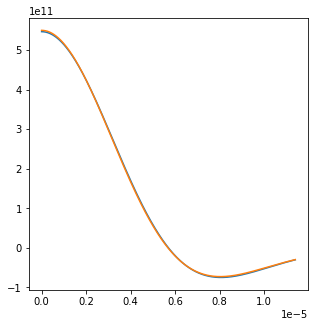

In [20]:
## comparing E_z at z=0 and t=0 (i.e. transverse field distribution)

# original (Salamin) field model
# calculate Rayleigh range
z_R = (omega_0*w_0**2)/(2*c)
# perturbation parameter
eps = w_0/z_R
# amplitude factor
P_corr = 1 + 3*(eps/2)**2 + 9*(eps/2)**4
Amp = np.sqrt(8*P/(P_corr*np.pi*e_0*c)) * (omega_0/(2*c))

r = np.linspace(0, 2, 500)*w_0
z = 0.0*z_R

rho = r/w_0

phi_G = np.arctan(z/z_R)
trans = np.exp(-(rho)**2)

E_z = np.real(Amp*trans*((1 - rho**2)*eps**2 + ((1/2) + (1/2)*rho**2 - (5/4)*rho**4 + (1/4)*rho**6)*eps**4))

## April field model
# amplitude factor
Amp = -1*np.sqrt(8*P/(np.pi*e_0*c))*a*c/(2*omega_0)

R_t = np.sqrt(r**2 + (1j*a)**2)
t_p = R_t/c + 1j*a/c
t_m = -R_t/c + 1j*a/c
f_zero_p = (1-1j*omega_0*t_p/s)**(-(s+1))
f_zero_m = (1-1j*omega_0*t_m/s)**(-(s+1))
f_one_p = (s+1)*(1j*omega_0/s)*(1-1j*omega_0*t_p/s)**(-(s+2))
f_one_m = (s+1)*(1j*omega_0/s)*(1-1j*omega_0*t_m/s)**(-(s+2))
f_two_p = (s+2)*(s+1)*(1j*omega_0/s)**2 * (1-1j*omega_0*t_p/s)**(-(s+3))
f_two_m = (s+2)*(s+1)*(1j*omega_0/s)**2 * (1-1j*omega_0*t_m/s)**(-(s+3))
Gm_zero = f_zero_p - f_zero_m
Gm_one = f_one_p - f_one_m
Gp_one = f_one_p + f_one_m
Gm_two = f_two_p - f_two_m
Gp_two = f_two_p + f_two_m
Ct = (1j*a)/R_t
St = r/R_t
S2t = 2*St*Ct
CEP_term = np.exp(1j*(np.pi/2))

E_z_April = np.real(CEP_term * (Amp/R_t) * (((3*Ct**2 - 1)/R_t) * (Gm_zero/R_t - Gp_one/c) - (St**2*Gm_two/c**2)))

fig = plt.figure(figsize=[5, 5])
plt.plot(r, E_z)
plt.plot(r, E_z_April)

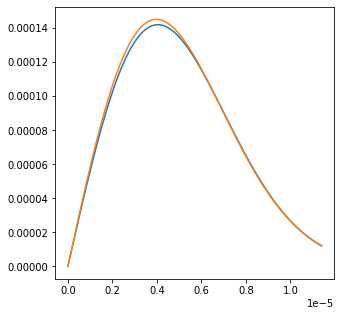

In [21]:
## comparing E_r at z=0 and t=0 (i.e. transverse field distribution)

# original (Salamin) field model
# calculate Rayleigh range
z_R = (omega_0*w_0**2)/(2*c)
# perturbation parameter
eps = w_0/z_R
# amplitude factor
P_corr = 1 + 3*(eps/2)**2 + 9*(eps/2)**4
Amp = np.sqrt(8*P/(P_corr*np.pi*e_0*c)) * (omega_0/(2*c))

r = np.linspace(0, 2, 500)*w_0

rho = r/w_0
trans = np.exp(-(rho)**2)

E_r = np.real(Amp*trans*(eps +
                       (-(1/2) + rho**2 - (1/4)*rho**4)*eps**3 +
                       (-(3/8) - (3/8)*rho**2 + (17/16)*rho**4 -
                        (3/8)*rho**6 + (1/32)*rho**8)*eps**5)*np.exp(+1j*np.pi/2)*rho)

## April field model
# amplitude factor
Amp = -1*np.sqrt(8*P/(np.pi*e_0*c))*a*c/(2*omega_0)

R_t = np.sqrt(r**2 + (1j*a)**2)
t_p = R_t/c + 1j*a/c
t_m = -R_t/c + 1j*a/c
f_zero_p = (1-1j*omega_0*t_p/s)**(-(s+1))
f_zero_m = (1-1j*omega_0*t_m/s)**(-(s+1))
f_one_p = (s+1)*(1j*omega_0/s)*(1-1j*omega_0*t_p/s)**(-(s+2))
f_one_m = (s+1)*(1j*omega_0/s)*(1-1j*omega_0*t_m/s)**(-(s+2))
f_two_p = (s+2)*(s+1)*(1j*omega_0/s)**2 * (1-1j*omega_0*t_p/s)**(-(s+3))
f_two_m = (s+2)*(s+1)*(1j*omega_0/s)**2 * (1-1j*omega_0*t_m/s)**(-(s+3))
Gm_zero = f_zero_p - f_zero_m
Gm_one = f_one_p - f_one_m
Gp_one = f_one_p + f_one_m
Gm_two = f_two_p - f_two_m
Gp_two = f_two_p + f_two_m
Ct = (1j*a)/R_t
St = r/R_t
S2t = 2*St*Ct
CEP_term = np.exp(1j*(np.pi/2))

E_r_April = np.real(CEP_term * (3*Amp*S2t/(2*R_t)) * ((Gm_zero/R_t**2) - (Gp_one/(c*R_t)) + (Gm_two/(3*c**2))))

fig = plt.figure(figsize=[5, 5])
plt.plot(r, E_r)
plt.plot(r, E_r_April)

In [20]:
# loop and test many different r_0 positions

NA = 0.1
half_angle = np.arcsin(NA)
a = 2/(np.sin(half_angle)*np.tan(half_angle)*2*np.pi/lambda_0)  # set confocal parameter
w_0 = 2/(np.tan(half_angle)*2*np.pi/lambda_0)  # set beam waist

P = 100e12  # FL power

r_0 = np.linspace(0, 0.2, 20)*w_0

KE_final = np.zeros(len(r_0))
KE_final_April = np.zeros(len(r_0))

for i in range(0, len(r_0)):
    t, z, r, v_z, v_r, KE = RPLB_acc_NoSTC_2D(lambda_0, tau_0, w_0, P, 0.0, 0.0, t_0, 0.0, r_0[i], 0.0)
    t_April, z, r, v_z, v_r, KE_April = RPLB_acc_NoSTCApril_2D(lambda_0, s, a, P, 0.0, t_0, 0.0, r_0[i], 0.0)
    KE_final[i] = KE[-1]
    KE_final_April[i] = KE_April[-1]
    print(str(i))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


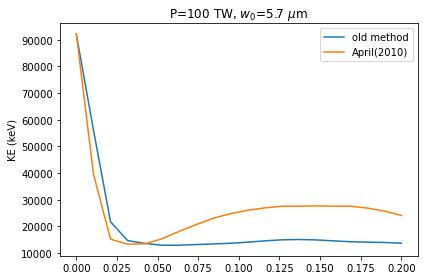

In [22]:
plt.plot(r_0/w_0, KE_final/1e3)
plt.plot(r_0/w_0, KE_final_April/1e3)
plt.legend(['old method', 'April(2010)'], loc=0)
plt.title('P='+'{0:.3g}'.format(P/1e12)+' TW, $w_0$='+'{0:.3g}'.format(1e6*w_0)+r' $\mu$m')
plt.ylabel('KE (keV)')
plt.tight_layout()